In [1]:
!pip install pypdfium2



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:

import fitz  # PyMuPDF
import numpy as np
# Load PDF
doc = fitz.open("AUTHORING_APP_236c2206_drw_PROE.pdf")
page = doc[0]

# Extract vector paths
drawings = page.get_drawings()
arr=[]
# Identify arrow-like vector shapes
for drawing in drawings:
    for item in drawing["items"]:
        arr.append(item[0])
print(np.unique(arr))


['c' 'l' 'qu']


In [1]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import fitz  # PyMuPDF
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans

In [2]:
# ---- 1. Load the model ----

model = YOLO('best_of_best_2.pt')


In [3]:

# ---- 2. Define preprocessing ----
transform = transforms.Compose([
    transforms.Resize((640, 640)), # Resize to match input size
    transforms.ToTensor(), 
   # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [4]:
# ---- 3. Load PDF and convert to images ----
def load_pdf_as_images(pdf_path):
    doc = fitz.open(pdf_path)
    images = []
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        zoom = 300 / 72
        mat = fitz.Matrix(zoom, zoom)
        pix = page.get_pixmap(matrix=mat)
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        pix.save(f"image_BAE"+str(page_num)+f".png")
        images.append(img)
    return images


In [7]:
def box_coordinates(image_old,image_new,boxes):
    scaled_boxes = []
    H_old,W_old,_ = image_old.shape
    H_new,W_new = image_new
    print("image_old",image_old.shape)
    print("image_new",image_new)
    
    for (x1_new, y1_new, x2_new, y2_new) in boxes:
        x1_original = int(x1_new * W_old / W_new)
        y1_original = int(y1_new * H_old / H_new)
        x2_original = int(x2_new * W_old / W_new)
        y2_original = int(y2_new * H_old / H_new)
        scaled_boxes.append((x1_original, y1_original, x2_original, y2_original))
    return scaled_boxes
    
# ---- 4. Predict on images ----
def predict_on_pdf(pdf_path):
    images = load_pdf_as_images(pdf_path)
    predictions = []
    image_original = cv2.imread("image_BAE2.png", cv2.COLOR_BGR2RGB)
   # for img in images:
        # Preprocess the image
    img= images[2]
    input_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        output = model(input_tensor,save=True)
        predictions = (output[0].boxes.xyxy.numpy())
        
        predictions_scaled = box_coordinates(image_original,(640,640),predictions)
        
        class_list =output[0].boxes.cls
    return predictions_scaled ,class_list


In [8]:

# ---- 5. Run prediction ----
pdf_path = 'AUTHORING_APP_116e3300_rev H_drw_PROE.pdf'
predictions,class_list = predict_on_pdf(pdf_path)
print(f"Predictions: {predictions}",f"class_list: {class_list}")


0: 640x640 6 Tables, 1 drawings, 1 main_drawing, 211.4ms
Speed: 0.0ms preprocess, 211.4ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict
image_old (10200, 13200, 3)
image_new (640, 640)
Predictions: [(11095, 338, 13038, 917), (2898, 8614, 4171, 9478), (158, 9596, 1209, 9895), (366, 1225, 12831, 5531), (8923, 9646, 10618, 9859), (1532, 5669, 13200, 8587), (10686, 9461, 13034, 9873), (3627, 1317, 5067, 3905)] class_list: tensor([0., 0., 0., 3., 0., 0., 0., 2.])


In [33]:
pdf_path = 'AUTHORING_APP_116e3300_rev H_drw_PROE.pdf'
load_pdf_as_images(pdf_path)

[<PIL.Image.Image image mode=RGB size=13200x10200>,
 <PIL.Image.Image image mode=RGB size=13200x10200>,
 <PIL.Image.Image image mode=RGB size=13200x10200>,
 <PIL.Image.Image image mode=RGB size=13200x10200>,
 <PIL.Image.Image image mode=RGB size=13200x10200>]

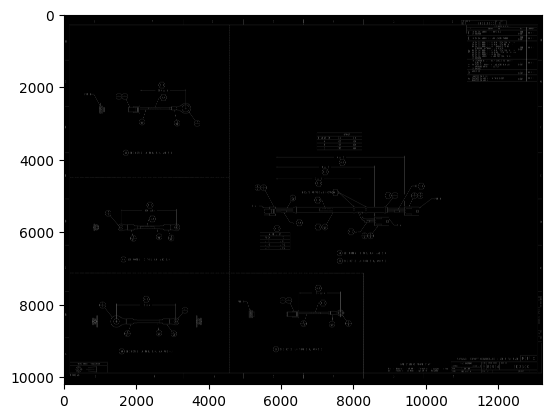

In [60]:
import cv2
import numpy as np

# Load image
image = cv2.imread("image_BAE1.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur
#blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Edge detection
edges = cv2.Canny(gray, np.min(gray), 255)

# Show edges
plt.imshow( edges,cmap="gray")


In [72]:
!pip install pytesseract
import pytesseract

pytesseract.pytesseract.tesseract_cmd = r"C:\Users\Charu.Jain\AppData\Local\Programs\Tesseract-OCR\tesseract.exe"


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [70]:
import cv2
import numpy as np
import pytesseract

doc = fitz.open("AUTHORING_APP_116e3300_rev H_drw_PROE.pdf")
page = doc[2]
# Load the image
image = cv2.imread("image_BAE1.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges_image = cv2.Canny(gray, np.min(gray), 255)

# Detect circles using Hough Transform
circles = cv2.HoughCircles(
    gray, 
    cv2.HOUGH_GRADIENT, dp=1, minDist=10, 
    param1=250, param2=70, minRadius=40, maxRadius=100
)
DPI = 300
scale = DPI / 72
# If circles are detected, draw them
if circles is not None:
    circles = np.uint16(np.around(circles))  # Convert to integers
    for circle in circles[0, :]:
        x_center, y_center, radius = circle
        x, y, w, h = x_center - radius, y_center - radius, 2 * radius, 2 * radius
        roi_cropped = gray[y:y+h, x:x+w]
        text = page.get_text("text",clip=(int(x/scale),int(y/scale),int((x+w)/scale),int((y+h)/scale)))
        
        if text !="":
            print("circle centre : ",x_center/scale,y_center/scale," Text", text)
            cv2.circle(image, (x_center, y_center), radius, (0, 255, 0), 12)  # Draw outer circle
            cv2.circle(image, (x_center, y_center), 2, (0, 0, 255), 3)  # Draw center
        
# Show result
cv2.imwrite("draw_circles_BAE2.png",image)

circle centre :  2673.12 1886.8799999999999  Text 2
1

circle centre :  1241.28 1887.36  Text 4
8

circle centre :  1271.52 835.1999999999999  Text 1
3

circle centre :  1180.8 495.35999999999996  Text 3
2

circle centre :  2200.3199999999997 544.3199999999999  Text 4
AR

circle centre :  1956.9599999999998 1236.0  Text G13

circle centre :  279.84 902.4  Text G12

circle centre :  1916.6399999999999 1989.6  Text 2
1

circle centre :  1830.7199999999998 2240.16  Text G11

circle centre :  2257.9199999999996 1969.9199999999998  Text 2
1

circle centre :  284.15999999999997 601.92  Text 6
2

circle centre :  2283.3599999999997 851.04  Text 5
AR

circle centre :  612.9599999999999 1653.12  Text 6
2

circle centre :  2223.8399999999997 744.4799999999999  Text 7
4

circle centre :  325.44 601.4399999999999  Text 1
1

circle centre :  2568.48 798.2399999999999  Text 6
AR

circle centre :  1185.12 386.88  Text 6
AR

circle centre :  1363.6799999999998 755.52  Text 6
AR

circle centre :  654.2

True

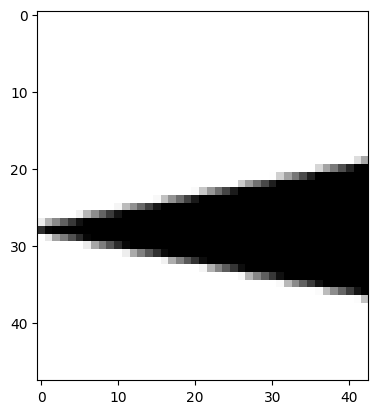

In [49]:
template = cv2.imread("arrowhead.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(template,cmap="gray")

In [10]:

def get_angle(line):
    """Compute the absolute angle of a line in degrees (0 to 180)."""
    x1, y1, x2, y2 = line
    angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
    return angle if angle >= 0 else angle + 180  # Ensure angles are within [0, 180]

def distance(p1, p2):
    """Euclidean distance between two points."""
    return np.linalg.norm(np.array(p1) - np.array(p2))

def merge_lines(lines, angle_thresh=5, distance_thresh=5):
    """
    Merges nearby collinear line segments.
    
    :param lines: List of lines from cv2.HoughLinesP()
    :param angle_thresh: Angle threshold (in degrees) for collinearity
    :param distance_thresh: Max distance between two line endpoints to merge
    :return: Merged lines
    """
    merged_lines = []
    used = set()
    
    for i, line1 in enumerate(lines):
        if i in used:
            continue
        
        x1, y1, x2, y2 = line1[0]
        angle1 = get_angle((x1, y1, x2, y2))
        merged = False
        
        for j, line2 in enumerate(lines):
            if i == j or j in used:
                continue
            
            x3, y3, x4, y4 = line2[0]
            angle2 = get_angle((x3, y3, x4, y4))
            
            if abs(angle1 - angle2) < angle_thresh:  # Check collinearity
                points = [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
                points.sort()  # Sort by x (or y if nearly vertical)
                
                if distance(points[1], points[2]) < distance_thresh:  # Check proximity
                    x1, y1 = points[0]
                    x2, y2 = points[3]
                    merged_lines.append([[x1, y1, x2, y2]])
                    used.add(j)
                    merged = True
        
        if not merged:
            merged_lines.append([[x1, y1, x2, y2]])
        used.add(i)

    return merged_lines

In [12]:
import cv2
import numpy as np
import math
# Load the main image and template
main_image = cv2.imread("draw_circles_BAE2.png")
template = cv2.imread("arrowhead.png")

# Convert to grayscale for better accuracy
gray_main = cv2.cvtColor(main_image, cv2.COLOR_BGR2GRAY)
gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

edges_image = cv2.Canny(gray_main, np.min(gray_main), 255)
edges_template = cv2.Canny(template, np.min(gray_template), 255)

h_main,w_main = gray_main.shape
h, w = gray_template.shape

print(np.sum(edges_template == 0))

results = {}  
center = (w // 2, h // 2)  # Rotation center

# Loop through different angles (0 to 360 degrees)
for angle in range(0, 360, 90):  # Rotate every 30 degrees
    # Get rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Perform rotation
    rotated = cv2.warpAffine(edges_template, M, (w, h))
    results[angle]= cv2.matchTemplate(edges_image, rotated, cv2.TM_CCORR_NORMED)
    #cv2.imwrite("rotated_template_image_"+str(angle)+".png",rotated)

arrows=[]
for flip_type, result in results.items():
    # Define a threshold for good matches
    threshold = 0.40  # Adjust based on accuracy needs
    locations = np.where(result >= threshold)
    for pt in zip(*locations[::-1]):  # Reverse (y, x) to (x, y)
        roi = gray_main[pt[1]:pt[1] + h, pt[0]:pt[0] + w]
        black_pixels = np.sum(roi == 0)
        if black_pixels >330:
            cv2.rectangle(main_image, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)
            arrows.append([pt[0],pt[1], pt[0] + w, pt[1] + h])

#Finding dimension lines and reading dimensions  horizontally 
#Find vertical dimension lines
for arr_x,arr_y,arr_w,arr_h in arrows:
    find_line_roi_h =edges_image[arr_y: arr_y+h,0:w_main]
    lines_h = cv2.HoughLinesP(find_line_roi_h, 1, np.pi/180, threshold=100,minLineLength=15, maxLineGap=10)
    
    find_line_roi_v =edges_image[0:h_main,arr_x: arr_x+w]
    lines_v = cv2.HoughLinesP(find_line_roi_v, 1, np.pi/180, threshold=100,minLineLength=15, maxLineGap=10)
    
    if lines_h is not None:
        for line in lines_h:
            x1, y1, x2, y2 = line[0]
            #cv2.circle(main_image, (x1, y1+arr_y), 2, (255, 0, 255), 3)
            #cv2.circle(main_image, (x2, y2+arr_y), 2, (0, 0, 255), 3)
            cv2.line(main_image, (x1, y1+arr_y), (x2, y2+arr_y), (255, 0, 0), 2)
            
    if lines_v is not None:
        for line in lines_v:
            x1, y1, x2, y2 = line[0]
            #cv2.circle(main_image, (x1, y1+arr_y), 2, (255, 0, 255), 3)
            #cv2.circle(main_image, (x2, y2+arr_y), 2, (0, 0, 255), 3)
            cv2.line(main_image, (x1+arr_x, y1), (x2+arr_x, y2), (255, 0, 0), 2)

#Finding extension lines horizontally and vertically
# Show the result
cv2.imwrite("draw_circles_arrowheads_BAE2.png",main_image)

1978


True

In [73]:
!pip install shapely

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ----------------------------- ---------- 1.0/1.4 MB 5.9 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 5.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [161]:
!pip install rtree networkx



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Load template  
Load main image  
Iterate over main image and match template  
Iterate matching of template over all angles from 0 ,90,180,270 and create a list of best matched positions  
Load all the lines items stored in vector graphics in pdf  
for loop over line items:  
&emsp;check if line intersects with the matched template box over all angles  
&emsp;find triangles in the lines filtered intersecting with the template
&emsp;filter lines in triangles to get lines which are exclusively dimension lines
&emsp;remove dimension lines and triangles lines from line items
for loop over filtered line items:
&emsp;find interesections with triangles in the remaining which likely would be extension lines   

we should have :  
dimension_line=[]  
arrow triangles =[]  
extension lines =[]  
    
    
    

In [58]:
def round_coords(line, decimals=6):
    return LineString([(round(x, decimals), round(y, decimals)) for x, y in line.coords])
    
def line_intersects_rect(arrow_boxes,p1,p2,main_image):
    h_main,w_main,_ = main_image.shape
    DPI = 300
    scale = DPI / 72
    (x0, y0) = p1
    (x1, y1) = p2
    sx0, sy0, sx1, sy1 = x0 * scale, y0 * scale, x1 * scale, y1 * scale
    side_type = None
    for arrow_x,arrow_y,arrow_h,arrow_w,score,angle in arrow_boxes :
        roi_rect_h = 0, arrow_y/scale, w_main/scale, (arrow_y+arrow_h)/scale 
        roi_h = fitz.Rect(*roi_rect_h)
       # cv2.rectangle(main_image, (0,int(arrow_y)), (int(w_main) , int(arrow_y + arrow_w) ), (0, 0, 255), 2)
        
        roi_rect_v = arrow_x/scale, 0, (arrow_x+arrow_w)/scale , (h_main)/scale
        roi_v = fitz.Rect(*roi_rect_v)
       # cv2.rectangle(main_image, (int(arrow_x),0), (int(arrow_x+arrow_h) , int(h_main) ), (0, 0, 255), 2)
    
        orientation_h = (roi_h.contains(fitz.Point(x0, y0)) and roi_h.contains(fitz.Point(x1, y1)))
        orientation_v = (roi_v.contains(fitz.Point(x0, y0)) and roi_v.contains(fitz.Point(x1, y1)))
        #print(orientation_h or orientation_v)
        if orientation_h or orientation_v:
            polygon = Polygon([(arrow_x,arrow_y), (arrow_x+arrow_w, arrow_y), (arrow_x+arrow_w, arrow_y+arrow_h), ( arrow_x, arrow_y+arrow_h),(arrow_x,arrow_y)])
            pts = np.array(polygon.exterior.coords, dtype=np.int32)
            cv2.polylines(main_image, [pts], isClosed=True, color=(255, 255, 0), thickness=12)

            min_x, min_y, max_x, max_y = polygon.bounds # Get polygon center
         
            line2 = LineString([(sx0, sy0), (sx1, sy1)])
            cv2.line(main_image, (int(sx0), int(sy0)),  (int(sx1), int(sy1)), color=(0, 255, 255), thickness=12)
            
            buffer_size = 0.01
            intersection = polygon.intersection(line2)
      
            for pt in intersection.coords:
                point = Point(pt)
                if point.y == min_y:
                    side_type ="TOP"
                   # print(f"Point {pt} is on the TOP side of the polygon")
                elif point.y == max_y:
                    side_type ="BOTTOM"
                   # print(f"Point {pt} is on the BOTTOM side of the polygon")
                elif point.x == min_x:
                    side_type ="LEFT"
                   # print(f"Point {pt} is on the LEFT side of the polygon")
                elif point.x == max_x:
                    side_type ="RIGHT"
                  #  print(f"Point {pt} is on the RIGHT side of the polygon")
                else:
                    side_type="INSIDE"
            
            if (intersection or line2.touches(polygon)) :
                #if (side_type=="INSIDE") :
                  #  return (False,None)
            #    else:
                return (True,side_type)
            

    return (False,None)
def rotate_image_with_padding(image, angle):
    """
    Rotates an image and pads it to ensure the full image is retained.
    
    :param image: Input image (NumPy array)
    :param angle: Rotation angle in degrees (positive = counterclockwise, negative = clockwise)
    :return: Rotated and padded image
    """
    (h, w) = image.shape[:2]  # Get original width and height
    
    center = (w // 2, h // 2)  # Find the center of the image

    # Compute the rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Compute new bounding box size
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))

    # Adjust the rotation matrix to shift the image to the center
    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]
   
    # Rotate and pad the image
    rotated = cv2.warpAffine(image, M, (new_w, new_h),borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255,))  # White padding
    return rotated

def non_max_suppression(boxes, overlapThresh=0.3):
    if len(boxes) == 0:
        return []
    
    boxes = np.array(boxes)
    x1, y1, h, w, scores = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3], boxes[:, 4]
    x2, y2 = x1 + w, y1 + h

    # Compute area
    areas = w * h
    indices = np.argsort(scores)[::-1]  # Sort by confidence

    picked = []
    while len(indices) > 0:
        i = indices[0]  # Pick the highest-scoring box
        picked.append(boxes[i])

        # Compute IoU
        xx1 = np.maximum(x1[i], x1[indices[1:]])
        yy1 = np.maximum(y1[i], y1[indices[1:]])
        xx2 = np.minimum(x2[i], x2[indices[1:]])
        yy2 = np.minimum(y2[i], y2[indices[1:]])

        w_inter = np.maximum(0, xx2 - xx1)
        h_inter = np.maximum(0, yy2 - yy1)
        intersection = w_inter * h_inter

        iou = intersection / (areas[i] + areas[indices[1:]] - intersection)
        
        # Keep boxes with IoU < threshold
        indices = indices[np.where(iou < overlapThresh)[0] + 1]

    return picked
    
def angle_between_lines(line1, line2):
    # Convert LineString to vectors
    x1, y1, x2, y2 = *line1.coords[0], *line1.coords[1]
    x3, y3, x4, y4 = *line2.coords[0], *line2.coords[1]

    # Compute direction vectors
    v1 = (x2 - x1, y2 - y1)
    v2 = (x4 - x3, y4 - y3)

    # Compute dot product and magnitudes
    dot_product = v1[0] * v2[0] + v1[1] * v2[1]
    mag_v1 = math.sqrt(v1[0]**2 + v1[1]**2)
    mag_v2 = math.sqrt(v2[0]**2 + v2[1]**2)
    # Prevent division by zero
    if mag_v1 == 0 or mag_v2 == 0:
        return None  # Undefined angle

    # Clamp value to [-1,1] to avoid domain error in acos()
    cos_theta = max(-1, min(1, dot_product / (mag_v1 * mag_v2)))

    # Compute angle in radians and convert to degrees
    angle_rad = math.acos(cos_theta)
    angle_deg = math.degrees(angle_rad)

    return angle_deg
    
def build_graph(lines):
    """
    Build a graph where intersections are nodes and line segments are edges.
    
    Parameters:
    - lines (list of LineString): List of line segments.
    
    Returns:
    - Graph (networkx.Graph): Graph representation of intersections.
    """
    graph = nx.Graph()
    spatial_index = index.Index()

    # Add lines to R-tree for fast lookup
    for i, line in enumerate(lines):
        spatial_index.insert(i, line.bounds)

    # Check intersections efficiently
    for i, line1 in enumerate(lines):
        possible_matches = list(spatial_index.intersection(line1.bounds))

        for j in possible_matches:
            if i >= j:  # Avoid duplicate checks
                continue

            line2 = lines[j]
            intersection = line1.intersection(line2)

            if intersection.geom_type == "Point":
                graph.add_node(tuple(intersection.coords[0]))  # Add intersection point as a node
                graph.add_edge(tuple(line1.coords[0]), tuple(line1.coords[1]))  # Add edges
                graph.add_edge(tuple(line2.coords[0]), tuple(line2.coords[1]))

    return graph

def find_triangles(graph):
    """
    Find all unique triangles in the graph.
    
    Parameters:
    - graph (networkx.Graph): Graph of intersections.
    
    Returns:
    - List of Polygon objects representing triangles.
    """
    triangles = []
    
    for cycle in nx.cycle_basis(graph):  # Finds all cycles in the graph
        if len(cycle) == 3:  # Check if it's a triangle
            triangles.append(Polygon(cycle))
    
    return triangles
    
def sort_coordinates(line):
    """Sort the coordinates of the line in ascending order to avoid reverse direction mismatch."""
    coords = list(line.coords)
    return tuple(sorted(coords))


def remove_triangle_lines(lines, triangles):
    """
    Removes lines that are part of detected triangles.

    Parameters:
    - lines (list of LineString): List of original lines.
    - triangles (list of Polygon): List of detected triangles.

    Returns:
    - List of LineString: Filtered lines that are NOT part of any triangle.
    """
    # Collect all edges that form triangles
    triangle_edges = set()
    for triangle in triangles:
        coords = list(triangle.exterior.coords[:-1])  # Remove duplicate closing point
        for i in range(len(coords)):
            edge = LineString([coords[i], coords[(i+1) % len(coords)]])
            triangle_edges.add(edge)

    normalized_triangle_edges = {sort_coordinates(edge) for edge in triangle_edges}
    
    # Normalize the lines in the list and remove those matching the triangle edges
    remaining_lines = [
        line for line in lines if sort_coordinates(line) not in normalized_triangle_edges
    ]
    
    return remaining_lines
    
    """
    Removes overlapping circles based on IoU threshold.
    
    :param circles: List of Shapely circles
    :param iou_threshold: IoU threshold for suppression
    :return: List of non-overlapping circles
    """
def iou(circle1, circle2):
    """Compute the Intersection over Union (IoU) between two circles."""
    inter_area = circle1.intersection(circle2).area
    union_area = unary_union([circle1, circle2]).area
    return inter_area / union_area if union_area > 0 else 0

def remove_overlapping_circles(circles, iou_threshold=0.3):
    """
    Removes overlapping circles based on IoU threshold.
    
    :param circles: List of Shapely circles
    :param iou_threshold: IoU threshold for suppression
    :return: List of non-overlapping circles
    """
    non_overlapping = []

    # Sort by area (or another criterion)
   # sorted_circles = sorted(circles, key=lambda c: c.area, reverse=True)

    for circle,radius in circles:
        if all(iou(circle, other) < iou_threshold for other in non_overlapping):
            non_overlapping.append([circle,radius])
        else:
            print(f"Removed circle at {circle.centroid} due to overlap.")

    return non_overlapping


In [78]:
import cv2
import numpy as np
import math
from shapely.geometry import LineString,Polygon,Point
import fitz
from rtree import index  # R-tree for fast spatial indexing
import networkx as nx
from shapely.ops import unary_union


# Load the main image and template
doc = fitz.open("AUTHORING_APP_116e3300_rev H_drw_PROE.pdf")
page = doc[4]

DPI = 300
scale = DPI / 72

main_image = cv2.imread("image_BAE4.png")
template = cv2.imread("arrowhead.png")

# Convert to grayscale for better accuracy
gray_main = cv2.cvtColor(main_image, cv2.COLOR_BGR2GRAY)
gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

edges_image = cv2.Canny(gray_main, np.min(gray_main), 255)
edges_template = cv2.Canny(template, np.min(gray_template), 255)

_, gray_main_binary = cv2.threshold(gray_main, 0, 255,  cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, gray_template_binary = cv2.threshold(gray_template, 0, 255,  cv2.THRESH_BINARY + cv2.THRESH_OTSU)

h_main,w_main = gray_main.shape
h,w = gray_template.shape

results = {}  
center = (w // 2, h // 2)  # Rotation center
arrows=[]

for angle in range(0, 360, 90):  # Rotate every 30 degrees
    # Get rotation matrix
    rotated = rotate_image_with_padding(gray_template_binary, angle) 
    results= cv2.matchTemplate(gray_main_binary, rotated, cv2.TM_CCOEFF_NORMED)
    h,w = rotated.shape

    # Define a threshold for good matches
    threshold = 0.90  # Adjust based on accuracy needs
    locations = np.where(results >= threshold)

    for pt in zip(*locations[::-1]):
        score = results[pt[1], pt[0]]
        arrows.append([pt[0],pt[1], h, w,score,angle])
        
filtered = non_max_suppression(arrows)
print("Filtered : ",len(filtered))
for i,(arr_x,arr_y,arr_h,arr_w,score,flip_type) in enumerate(filtered):
    cv2.putText(main_image, f"{flip_type}", (int(arr_x), int(arr_y) - 20),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.rectangle(main_image, (int(arr_x),int(arr_y)),(int(arr_x + arr_w) , int(arr_y + arr_h)) , (0, 0, 255), 2)
 
dimension_lines = []
filtered_lines = []
triangles = []

drawings = page.get_drawings()

line_items = [item for drawing in drawings for item in drawing["items"] if item[0] == "l"]

for i, line in enumerate(line_items):
    x0, y0, x1, y1 = line[1][0], line[1][1], line[2][0], line[2][1]  # Extract coordinates
    
    intersects_bool, side = line_intersects_rect(filtered, (x0, y0), (x1, y1),main_image)
    sx0, sy0, sx1, sy1 = x0 * scale, y0 * scale, x1 * scale, y1 * scale
    
    if intersects_bool:
        filtered_lines.append(LineString([(sx0, sy0), (sx1, sy1)]))
        
        graph = build_graph(filtered_lines)
        triangles = find_triangles(graph)
        
        for triangle in triangles:
            pts = np.array(triangle.exterior.coords[:-1], dtype=np.int32)
            cv2.polylines(main_image, [pts], isClosed=True, color=(0, 0, 255), thickness=22)

        dimension_lines = remove_triangle_lines(filtered_lines, triangles)
        
        for line in dimension_lines:
            # Convert LineString to a list of coordinates
            start = tuple(map(int, line.coords[0]))  # First coordinate
            end = tuple(map(int, line.coords[-1]))   # Last coordinate
            
            # Draw the line on the image using cv2.line
            cv2.line(main_image, start, end, color=(255, 0, 0), thickness=12)  # Red line
    
filtered_line_items = [line for line in line_items if LineString([(line[1][0]* scale, line[1][1]* scale), (line[2][0]* scale, line[2][1]* scale)]) not in filtered_lines]    

extension_lines=[]
for line in filtered_line_items:
    x0, y0, x1, y1 = line[1][0], line[1][1], line[2][0], line[2][1] 
    sx0, sy0, sx1, sy1 = x0 * scale, y0 * scale, x1 * scale, y1 * scale
    
    for tri in triangles:
        if tri.intersects(LineString([(sx0, sy0), (sx1, sy1)])):
            extension_lines.append(line)
            cv2.line(main_image, (int(sx0), int(sy0)), (int(sx1), int(sy1)), (0, 255, 0), 12)

find_part_line_items =[line for line in filtered_line_items if LineString([(line[1][0]* scale, line[1][1]* scale), (line[2][0]* scale, line[2][1]* scale)]) not in extension_lines]    

circles = cv2.HoughCircles(
    gray_main, 
    cv2.HOUGH_GRADIENT, dp=1, minDist=10, 
    param1=250, param2=80, minRadius=40, maxRadius=100
)

part_item=[]
part_lines=[]
if circles is not None:
    circles = np.uint16(np.around(circles))  # Convert to integers
    for circle in circles[0, :]:
        x_center, y_center, radius = circle
        x, y, w, h = x_center - radius, y_center - radius, 2 * radius, 2 * radius
        roi_cropped = gray_main[y:y+h, x:x+w]
        text = page.get_text("text",clip=(int(x/scale),int(y/scale),int((x+w)/scale),int((y+h)/scale)))
        
        if text !="":
            circle_item = Point(x_center, y_center).buffer(radius)
            part_item.append(circle_item)

print(len(part_item))
#filtered_circles = remove_overlapping_circles(part_item,0.1)
#print(len(filtered_circles))

for line in find_part_line_items:
    x0, y0, x1, y1 = line[1][0], line[1][1], line[2][0], line[2][1] 
    sx0, sy0, sx1, sy1 = x0 * scale, y0 * scale, x1 * scale, y1 * scale
    
    for part in part_item:    
        radius = Point(part.centroid.x,part.centroid.y).distance(part.boundary)
        cv2.circle(main_image, (int(part.centroid.x), int(part.centroid.y)), int(radius), (0, 165, 255), 12) 
        if ( part.touches(Point(sx0, sy0).buffer(5)) ^  part.touches(Point(sx1, sy1).buffer(5))  ) or ( part.intersects(Point(sx0, sy0).buffer(5)) ^  part.intersects(Point(sx1, sy1).buffer(5))  ) or (part.contains(Point(sx0, sy0).buffer(5)) ^  part.contains(Point(sx1, sy1).buffer(5))) or (part.covers(Point(sx0, sy0).buffer(5)) ^  part.covers(Point(sx1, sy1).buffer(5))):   
            cv2.line(main_image, (int(sx0), int(sy0)), (int(sx1), int(sy1)), (0, 255, 0), 12)
            part_lines.append(LineString([(sx0, sy0), (sx1, sy1)]))
          
            
cv2.imwrite("draw_circles_arrowheads_BAE4.png",main_image)

Filtered :  22
36


True

In [84]:
find_part_arrow_line_items =[line for line in find_part_line_items if LineString([(line[1][0]* scale, line[1][1]* scale), (line[2][0]* scale, line[2][1]* scale)]) not in part_lines]    

arrow_lines=[]
for line in find_part_arrow_line_items:
    x0, y0, x1, y1 = line[1][0], line[1][1], line[2][0], line[2][1] 
    sx0, sy0, sx1, sy1 = x0 * scale, y0 * scale, x1 * scale, y1 * scale
    for arrow_line in part_lines:
        if (LineString([(sx0, sy0), (sx1, sy1)]).intersects(arrow_line.buffer(10))):
            #cv2.line(main_image, (int(sx0), int(sy0)), (int(sx1), int(sy1)), (255, 0, 255), 12)
            arrow_lines.append(LineString([(sx0, sy0), (sx1, sy1)]))

graph = build_graph(arrow_lines)
triangles = find_triangles(graph)

for triangle in triangles:
    pts = np.array(triangle.exterior.coords[:-1], dtype=np.int32)
    print(pts)
    cv2.polylines(main_image, [pts], isClosed=True, color=(0, 0, 255), thickness=22)
            
cv2.imwrite("draw_circles_arrowheads_BAE4.png",main_image)


Given:  
dimension_line=[]  
dimension arrow triangles =[]  
extension lines =[]  
part_lines=[]  
part arrow triangles =[]

1. Extension line intersecting with arrow polygon intersecting with a line , check alignment left or right or top or bottom
2. if the y coordinate or x coordinate is common in intersections --> make that a pair
3. move the part circles to the intersecting point
4. extract the centre text and record the centre coordinate
5. drop the extension lines to the end and find the containing part numbers
6. Store the dimensions and part numbers in order in a data structure
   - store in DS such that the heirarchy is maintained
   - dimenions are associated with each part
8. Print the entire DS into a table
9. Handle corner cases where there is dimension mentioned in the below format
   - line extension line extension line and line with the dimension mentioned in the surrounding area
   - extension line line extension line and text containing dimension in the surrounding area
10. If multiple drawings present in a group check for the projection format , handle the top view and side view accordingly
     

In [ ]:
import cv2
import numpy as np
import pytesseract
import fitz
import matplotlib.pyplot as plt

doc = fitz.open("AUTHORING_APP_116e3300_rev H_drw_PROE.pdf")
page = doc[4]
# Load the image
image = cv2.imread("image_BAE4.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply GaussianBlur to reduce noise
#gray = cv2.GaussianBlur(gray, (9, 9), 2)
edges = cv2.Canny(gray,np.min(gray),255)
#plt.imshow(edges,cmap="gray")
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(image, contours, -1, (255, 0, 0), 2)  

for contour in contours:
    area = cv2.contourArea(contour)
    print(area)
    if area < 170 and area > 0:  # Adjust for small triangles
        epsilon = 0.01 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 3:
            cv2.drawContours(image, [approx], -1, (0, 0, 255), 2)

        
# Show result
cv2.imwrite("draw_triangles.png",image)

In [36]:
import cv2
import numpy as np

# Load image
image = cv2.imread("image_BAE1.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Thresholding to create binary image
_, thresh = cv2.threshold(gray, np.min(gray), 255, cv2.THRESH_BINARY_INV)

# Apply connected components to separate shapes
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=8)

# Create an output image
output = np.zeros_like(image)

for i in range(1, num_labels):  # Skip background (label 0)
    mask = (labels == i).astype(np.uint8) * 255  # Create mask for each component

    # Find contours for the separated object
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Check if the shape is a triangle (3 vertices)
        if len(approx) == 3:
            cv2.drawContours(output, [approx], -1, (0, 255, 0), 2)  # Draw detected triangles


cv2.imwrite("draw_triangles.png",image)

KeyboardInterrupt: 

In [ ]:
import numpy as np

# Function to compute IoU given two bounding boxes
def compute_iou(boxA, boxB):
    # Convert (x, y, width, height) → (x1, y1, x2, y2)
    x1_A, y1_A, x2_A, y2_A = boxA[0], boxA[1], boxA[0] + boxA[2], boxA[1] + boxA[3]
    x1_B, y1_B, x2_B, y2_B = boxB[0], boxB[1], boxB[0] + boxB[2], boxB[1] + boxB[3]

    # Compute intersection coordinates
    x_inter1 = max(x1_A, x1_B)
    y_inter1 = max(y1_A, y1_B)
    x_inter2 = min(x2_A, x2_B)
    y_inter2 = min(y2_A, y2_B)

    # Compute intersection width & height
    w_inter = max(0, x_inter2 - x_inter1)
    h_inter = max(0, y_inter2 - y_inter1)

    # Compute intersection area
    area_inter = w_inter * h_inter

    # Compute areas of both bounding boxes
    area_A = (x2_A - x1_A) * (y2_A - y1_A)
    area_B = (x2_B - x1_B) * (y2_B - y1_B)

    # Compute union area
    area_union = area_A + area_B - area_inter

    # Compute IoU
    iou = area_inter / area_union if area_union > 0 else 0
    return iou

# List of bounding boxes [(x, y, width, height)]
boxes = [
    (50, 50, 150, 150),  # Box 1
    (100, 100, 150, 150),  # Box 2 (overlaps with Box 1)
    (300, 300, 100, 100),  # Box 3 (no overlap)
]

# Loop over all pairs of boxes
for i in range(len(boxes)):
    for j in range(i + 1, len(boxes)):  # Avoid duplicate comparisons
        iou = compute_iou(boxes[i], boxes[j])
        print(f"IoU between Box {i+1} and Box {j+1}: {iou:.3f}")


In [ ]:


y_groups = defaultdict(list)
x_groups = defaultdict(list)

dimensions_dict_x = []
dimensions_dict_y = []
read_pattern= defaultdict(list)

pattern1 = ["left_arrow","dimension_line","text","dimension_line","right_arrow"]
pattern2 = ["dimension_line","right_arrow", "left_arrow","dimension_line"]
pattern3 = ["left_arrow","dimension_line","right_arrow"]

pattern4 = ["top_arrow","dimension_line","text","dimension_line","bottom_arrow"]
pattern5 = ["dimension_line","bottom_arrow", "top_arrow","dimension_line"]
pattern6 = ["bottom_arrow","dimension_line","top_arrow"]

for dim in dimension_lines:
    #print(dim)
    for x,y in dim.coords:
        y_groups[(y)].append(((x), (y)))
        x_groups[(x)].append(((x), (y)))

filtered_y = {k:sorted(list(set(v))) for k, v in y_groups.items() if len(list(set(v))) > 1}

for j, (key, value) in enumerate(filtered_y.items()):
    read_pattern.clear()
    min_distance = np.iinfo(np.int32).max
    
    for i in range(len(value)-1):
        dimensions_dict= defaultdict(list)
        
        y1=value[i][1] -40
        y2=value[i+1][1] +40
        x1=value[i][0] 
        x2=value[i+1][0] 

        line1 = LineString([(value[i]), (value[i+1])])
        line2 = LineString([(value[i+1]), (value[i])])
        
        if line1 in dimension_lines or line2 in dimension_lines:
            read_pattern[(x1)].append("dimension_line")
            
            for intersecting_dimension_arrows in dimension_arrow_triangles:
                if line1.intersects(intersecting_dimension_arrows):
                    if intersecting_dimension_arrows.centroid.x>=value[i][0] or intersecting_dimension_arrows.centroid.x>=value[i+1][0]:
                        read_pattern[intersecting_dimension_arrows.centroid.x].append("right_arrow")
                    else:
                        read_pattern[intersecting_dimension_arrows.centroid.x].append("left_arrow")
                        
        else:
            text = page.get_text("text", clip=(int(x1/scale),int(y1/scale),int(x2/scale),int(y2/scale)))
            
            centroid_x = (x2 + x1) / 2
            centroid_y = (y1 + y2) / 2

            if text != "":
                read_pattern[(centroid_x)].append("text")
                
        sorted_values = [read_pattern[k] for k in sorted(read_pattern)]
        flat_list = list(chain(*sorted_values))
       
        if flat_list == pattern1 :
          
            dimensions_dict["pattern"].append("pattern1")
            dimensions_dict["coords"].append([LineString([(value[i-2]), (value[i-1])]),LineString([(value[i]), (value[i+1])])])
            dimensions_dict["value"].append(text)
            dimensions_dict_x.append(dimensions_dict)
            read_pattern.clear()
        elif flat_list == pattern2 :
            
            dimensions_dict["pattern"].append("pattern2")
            dimensions_dict["coords"].append([LineString([(value[i-1]), (value[i])]),LineString([(value[i]), (value[i+1])])])
            dimensions_dict["value"].append("")
            dimensions_dict_x.append(dimensions_dict)
            read_pattern.clear()
        elif flat_list == pattern3 :
          #  print(flat_list)
            dimensions_dict["pattern"].append("pattern3")
            dimensions_dict["coords"].append([LineString([(value[i-1]), (value[i])])])
            dimensions_dict["value"].append("")
            dimensions_dict_x.append(dimensions_dict)
            read_pattern.clear()
            
filtered_x = {k: sorted(list(set(v))) for k, v in x_groups.items() if len(list(set(v))) > 1}

for j,(key, value) in enumerate(filtered_x.items()):
    read_pattern.clear()
    for i in range(len(value)-1):
        dimensions_dict= defaultdict(list)
        y1 = value[i][1] 
        y2 = value[i+1][1] 
        x1 = value[i][0] -250
        x2 = value[i+1][0] +250
        
        line1 = LineString([(value[i]), (value[i+1])])
        line2 = LineString([(value[i+1]), (value[i])])
        
        if line1 in dimension_lines or line2 in dimension_lines:
            read_pattern[(y1)].append("dimension_line")
            
            for intersecting_dimension_arrows in dimension_arrow_triangles:
                if line1.intersects(intersecting_dimension_arrows):
                    if intersecting_dimension_arrows.centroid.y>=value[i][1] or intersecting_dimension_arrows.centroid.y>=value[i+1][1]:
                        read_pattern[intersecting_dimension_arrows.centroid.y].append("bottom_arrow")
                    else:
                        read_pattern[intersecting_dimension_arrows.centroid.y].append("top_arrow")
                        
        else:
            text = page.get_text("text", clip=(int(x1/scale),int(y1/scale),int(x2/scale),int(y2/scale)))
            
            centroid_x = (x2 + x1) / 2
            centroid_y = (y1 + y2) / 2
                    
            if text != "":
                read_pattern[(centroid_y)].append("text")
                
        sorted_values = [read_pattern[k] for k in sorted(read_pattern)]
        flat_list = list(chain(*sorted_values))
       
        if flat_list == pattern4 :
            dimensions_dict["pattern"].append("pattern4")
            dimensions_dict["coords"].append([LineString([(value[i-2]), (value[i-1])]),LineString([(value[i]), (value[i+1])])])
            dimensions_dict["value"].append(text)
            dimensions_dict_y.append(dimensions_dict)
            
            read_pattern.clear()
        elif flat_list == pattern5 :
           # print(flat_list)
            dimensions_dict["pattern"].append("pattern5")
            dimensions_dict["coords"].append([LineString([(value[i-1]), (value[i])]),LineString([(value[i]), (value[i+1])])])
            dimensions_dict["value"].append("")
            dimensions_dict_y.append(dimensions_dict)
            read_pattern.clear()
        elif flat_list == pattern6 :
            #print(flat_list)
            dimensions_dict["pattern"].append("pattern6")
            dimensions_dict["coords"].append([LineString([(value[i-1]), (value[i])])])
            dimensions_dict["value"].append("")
            dimensions_dict_y.append(dimensions_dict)
            read_pattern.clear()
    
print(len(dimensions_dict_y))
print(len(dimensions_dict_x))

for i,(item) in enumerate(dimensions_dict_y):
    print(f"{item["coords"][0],item["value"],item["pattern"]}")
    
for i,(item) in enumerate(dimensions_dict_x):
    print(f"{item["coords"][0],item["value"],item["pattern"]}")
